## clustering

In [236]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial
torch.manual_seed(42);
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)
from  torch.utils.data import WeightedRandomSampler

## Create data

In [141]:
n_clusters = 6
n_samples = 250

In [142]:
centroids = torch.rand(n_clusters, 2)*70-35
centroids

tensor([[ 26.759,  29.050],
        [ -8.200,  32.151],
        [ -7.669,   7.063],
        [-17.040,  20.555],
        [ 30.854, -25.677],
        [ 30.422,   6.551]])

In [143]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [144]:
slices= [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [145]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    for i,centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid,markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid,markersize=5, marker="x", color='m', mew=2)

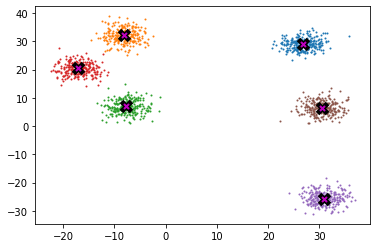

In [146]:
plot_data(centroids, data, n_samples)

## Kmeans

In [147]:
from sklearn.preprocessing import MinMaxScaler

torch.manual_seed(43);
k = 6
n_data = len(data)
d_labels = torch.randint(k,(n_data,))
d_labels, d_labels.shape

(tensor([4, 0, 5,  ..., 2, 3, 3]), torch.Size([1500]))

In [148]:
scaler = MinMaxScaler()
s_data = tensor( scaler.fit_transform(data) )
s_data

tensor([[0.819, 0.820],
        [0.811, 0.876],
        [0.891, 0.854],
        ...,
        [0.896, 0.577],
        [0.873, 0.501],
        [0.903, 0.520]], dtype=torch.float64)

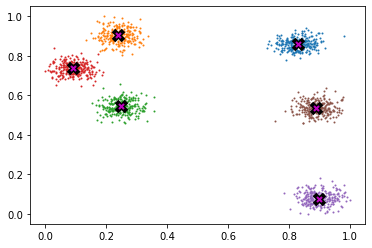

In [149]:
plot_data(scaler.transform(centroids), s_data, n_samples)

In [150]:
k_vec = torch.unique(d_labels, sorted=True)
k_vec

tensor([0, 1, 2, 3, 4, 5])

In [152]:
s_data

tensor([[0.819, 0.820],
        [0.811, 0.876],
        [0.891, 0.854],
        ...,
        [0.896, 0.577],
        [0.873, 0.501],
        [0.903, 0.520]], dtype=torch.float64)

In [154]:
s_data[d_labels == k_vec[0]].shape

torch.Size([264, 2])

In [155]:
ltest = d_labels[:10]
ltest, ltest == k_vec[0], 

(tensor([4, 0, 5, 1, 1, 2, 0, 3, 1, 1]),
 tensor([False,  True, False, False, False, False,  True, False, False, False]))

In [156]:
ltest[None].shape, labels[:,None].shape

(torch.Size([1, 10]), torch.Size([6, 1]))

In [157]:
masks = ltest[None] == k_vec[:,None]
masks, masks.shape

(tensor([[False,  True, False, False, False, False,  True, False, False, False],
         [False, False, False,  True,  True, False, False, False,  True,  True],
         [False, False, False, False, False,  True, False, False, False, False],
         [False, False, False, False, False, False, False,  True, False, False],
         [ True, False, False, False, False, False, False, False, False, False],
         [False, False,  True, False, False, False, False, False, False, False]]),
 torch.Size([6, 10]))

In [158]:
masked = s_data[:10] * masks[...,None]
masked.shape

torch.Size([6, 10, 2])

In [159]:
msum = masked.sum(axis=1)
msum

tensor([[1.688, 1.776],
        [3.243, 3.461],
        [0.888, 0.830],
        [0.852, 0.902],
        [0.819, 0.820],
        [0.891, 0.854]], dtype=torch.float64)

In [160]:
masks.shape

torch.Size([6, 10])

In [161]:
div = masks.sum(1)
div

tensor([2, 4, 1, 1, 1, 1])

In [162]:
msum/div[...,None]

tensor([[0.844, 0.888],
        [0.811, 0.865],
        [0.888, 0.830],
        [0.852, 0.902],
        [0.819, 0.820],
        [0.891, 0.854]], dtype=torch.float64)

In [163]:
def calc_centroids(data,k_vec,data_labels):
    #get masks for detecting points that correspond to every cluster
    masks = (data_labels[None] == k_vec[:,None])
    #get average of all points that correspond to every cluster
    #i.e.get centroids
    msum = (data * masks[...,None]).sum(1)
    div = masks[...,None].sum(1)
    return msum/div

In [165]:
centroids = calc_centroids(s_data,k_vec,d_labels)
centroids, centroids.shape

(tensor([[0.484, 0.622],
         [0.533, 0.607],
         [0.543, 0.589],
         [0.559, 0.591],
         [0.550, 0.646],
         [0.535, 0.608]], dtype=torch.float64),
 torch.Size([6, 2]))

In [167]:
distances = ( (centroids[:,None,:]-s_data)**2 ).sum(2).sqrt()
distances, distances.shape    

(tensor([[0.390, 0.414, 0.469,  ..., 0.415, 0.407, 0.432],
         [0.357, 0.386, 0.435,  ..., 0.364, 0.356, 0.380],
         [0.361, 0.392, 0.437,  ..., 0.353, 0.341, 0.366],
         [0.347, 0.380, 0.424,  ..., 0.338, 0.327, 0.352],
         [0.321, 0.348, 0.399,  ..., 0.353, 0.354, 0.375],
         [0.355, 0.385, 0.433,  ..., 0.363, 0.354, 0.379]], dtype=torch.float64),
 torch.Size([6, 1500]))

In [168]:
d_labels  = distances.argmin(dim=0)
d_labels

tensor([4, 4, 4,  ..., 3, 3, 3])

In [169]:
centroids = calc_centroids(data,k_vec,d_labels)
centroids, centroids.shape

(tensor([[-10.937,  19.788],
         [    nan,     nan],
         [    nan,     nan],
         [ 30.682,  -9.467],
         [ 26.780,  29.194],
         [    nan,     nan]]),
 torch.Size([6, 2]))

In [181]:
def calc_labels(centroids,data):
    distances = ( (centroids[:,None,:]-data)**2 ).sum(2).sqrt()
    labels = distances.argmin(dim=0)
    return labels

In [171]:
calc_labels(centroids, s_data)

tensor([0, 3, 0,  ..., 4, 4, 4])

In [170]:
torch.manual_seed(43);
centroids = s_data[torch.randint(n_data,(k,))].clone()
centroids

tensor([[0.793, 0.819],
        [0.945, 0.012],
        [0.251, 0.917],
        [0.773, 0.905],
        [0.850, 0.571],
        [0.847, 0.076]], dtype=torch.float64)

In [172]:
d_labels = calc_labels(centroids, s_data)
d_labels

tensor([0, 3, 0,  ..., 4, 4, 4])

In [173]:
centroids = calc_centroids(s_data,k_vec,d_labels)
centroids, centroids.shape

(tensor([[0.835, 0.846],
         [0.942, 0.069],
         [0.194, 0.727],
         [0.819, 0.888],
         [0.891, 0.537],
         [0.879, 0.086]], dtype=torch.float64),
 torch.Size([6, 2]))

In [177]:
def plot_kdata(centroids,data,d_labels,ax=None):
    if ax is None:
        _, ax = plt.subplots()
    labels = torch.unique(d_labels, sorted=True)
    for l in labels:
        points  = data[d_labels == l]
        ax.scatter(points[:,0],points[:,1], s=1)
        ax.plot(*centroids[l],markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroids[l],markersize=5, marker="x", color='m', mew=2)    

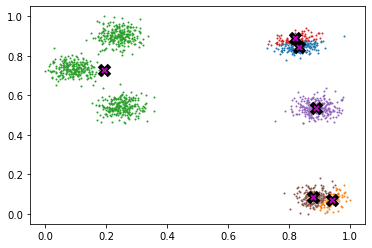

In [178]:
plot_kdata(centroids,s_data,d_labels)

In [185]:
def k_means(k,data):
    k_vector = tensor(range(k))
    #select randomly k centroids from data
    centroids = data[torch.randint(n_data,(k,))].clone()
    for i in range(30):
        d_labels = calc_labels(centroids,data)
        centroids = calc_centroids(data,k_vec,d_labels)
    return centroids, d_labels

In [209]:
torch.manual_seed(47);
k = 6
centroids, labels = k_means(k,s_data)

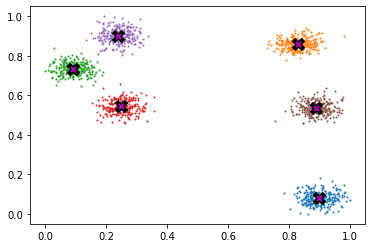

In [201]:
plot_kdata(centroids,s_data,labels)

In [220]:
from sklearn.cluster import KMeans

In [221]:
torch.manual_seed(5675);
kmeans = KMeans(n_clusters=k)
kmeans.fit(s_data)

KMeans(n_clusters=6)

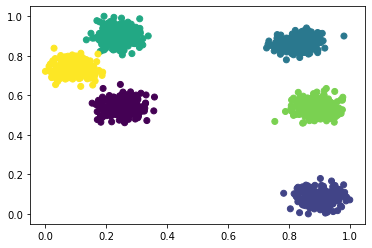

In [219]:
plt.scatter(s_data[:,0], s_data[:,1], c=kmeans.labels_)
plt.show() 

In [222]:
centroids = data[torch.randint(n_data,(1,))].clone()

In [224]:
centroids, centroids.shape 

(tensor([[28.922,  8.680]]), torch.Size([1, 2]))

In [ ]:
distances = ( (centroids[:,None,:]-data)**2 ).sum(2)

In [233]:
torch.cat((centroids,data[None,0])).shape

torch.Size([2, 2])

In [289]:
def kmeans_plusplus_init(data,k):
    #select first centroid randomly from data
    centroids = data[torch.randint(n_data,(1,))].clone()
    distances = torch.ones(len(data)) * torch.inf
    for i in range(k-1):
        #calculate distances of datapoints to newest centroid
        dist_kth = ( (centroids[-1]-data)**2 ).sum(1)
        #keep minimum distances among centroids
        distances = torch.minimum(distances,dist_kth)
        #select next centroid with weighted probability  using distances as weights
        cent_idx = list(WeightedRandomSampler(weights=distances, num_samples=1, replacement=False))[0]
        centroids = torch.cat((centroids,data[None,cent_idx]))
    return centroids

In [324]:
def k_means_plusplus(k,data):
    k_vector = tensor(range(k))
    centroids = kmeans_plusplus_init(data,k)
    prev_labels = torch.randint(k,(len(data),))
    for i in range(50):
        d_labels = calc_labels(centroids,data)
        centroids = calc_centroids(data,k_vec,d_labels)
        if torch.all( prev_labels.eq(d_labels) ): break
        prev_labels = d_labels.clone()
        #print(i)
    return centroids, d_labels

In [339]:
#torch.manual_seed(8);
k = 6
centroids, labels = k_means_plusplus(k,s_data)
#plot_kdata(centroids,s_data,labels)

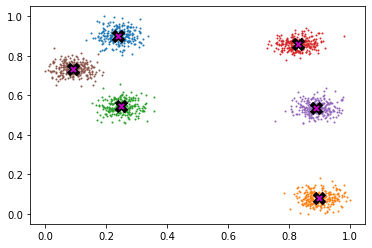

In [340]:
plot_kdata(centroids,s_data,labels)